<a href="https://colab.research.google.com/github/pachterlab/Clytia_single_cell_2020/blob/master/notebooks/neuronSubpop_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Tue Aug 18 00:13:31 UTC 2020


In [2]:
#Kallisto bus clustered starvation data, h5ad
#CHANGE TO LINK WITH cellRanger_louvain LABEL
#!wget --quiet https://caltech.box.com/shared/static/4jr6eqg6qnnrj2c8orlf7fwo7scyj6s1
!wget --quiet https://caltech.box.com/shared/static/13jsqkczkskrf6cau9p4evhnmqyp7jn3

#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
!wget --quiet https://caltech.box.com/shared/static/3l60szs0e9hgaax4q9dbuehgoo092xww

In [3]:
#Human ortholog annotations
!wget --quiet https://caltech.box.com/shared/static/slxs7968tths1xotumohnzwy6pgdtk6k

#Panther annotations
!wget --quiet https://caltech.box.com/shared/static/vx2iztm7tsyvg7rcj93h2w3hhjhn7jnt

#GO Terms
!wget --quiet https://caltech.box.com/shared/static/0ly6k9iwo1nc9dp5zxo8sw7qe0gt4oof

In [4]:
!pip install --quiet anndata
!pip install --quiet scanpy
!pip3 install --quiet leidenalg

!pip install --quiet louvain


     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 7.7MB 2.3MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 2.4MB 2.7MB/s 
     |████████████████████████████████| 3.2MB 22.9MB/s 
     |████████████████████████████████| 2.2MB 2.8MB/s 


In [5]:
!pip3 install rpy2

In [6]:
#Install Packages
import random
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

#import scrublet as scr

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")
%load_ext rpy2.ipython

In [7]:
#Read in h5ad file
bus_fs_combo = anndata.read("13jsqkczkskrf6cau9p4evhnmqyp7jn3")


#Read in annotations
from io import StringIO

hg_ortho_df = pd.read_csv(StringIO(''.join(l.replace('|', '\t') for l in open('slxs7968tths1xotumohnzwy6pgdtk6k'))),
            sep="\t",header=None,skiprows=[0,1,2,3])

hg_ortho_df[['XLOC','TCONS']] = hg_ortho_df[13].str.split(expand=True) 
hg_ortho_df[['Gene','gi']] = hg_ortho_df[3].str.split(expand=True) 
hg_ortho_df['Description']= hg_ortho_df[11]
#hg_ortho_df.head()

panther_df = pd.read_csv('vx2iztm7tsyvg7rcj93h2w3hhjhn7jnt',
            sep="\t",header=None) #skiprows=[0,1,2,3]

#panther_df.head()

goTerm_df = pd.read_csv('0ly6k9iwo1nc9dp5zxo8sw7qe0gt4oof',
            sep=" ",header=None) #skiprows=[0,1,2,3]

#goTerm_df.head()

bus_fs_combo

AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain'
    var: 'n_counts'
    uns: 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [28]:
#Neurons
neurons = bus_fs_combo[bus_fs_combo.obs['cellRanger_louvain'].isin([31,26,6,9])]
#sc.pp.filter_cells(neurons, min_counts=0)
sc.pp.filter_genes(neurons, min_counts=0)

sc.pp.highly_variable_genes(neurons,n_top_genes=3000)
neurons = neurons[:,neurons.var['highly_variable']]

sc.pp.scale(neurons, max_value=10)

sc.tl.pca(neurons, n_comps=60)
sc.pl.pca_variance_ratio(neurons, log=True)

#applyNCAEmbed(neurons,neurons.obs['knn_clus'])

sc.pp.neighbors(neurons,n_neighbors=15, n_pcs=15) #n_neighbors=5, n_pcs=15,use_rep='X_nca'
sc.tl.louvain(neurons,resolution=1,key_added='louvain_neur')#Clustering algorithm,resolution=0.5

In [22]:
neurons

AnnData object with n_obs × n_vars = 1387 × 2852
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'louvain_neur'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'hvg', 'louvain_neur_colors', 'cellRanger_louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

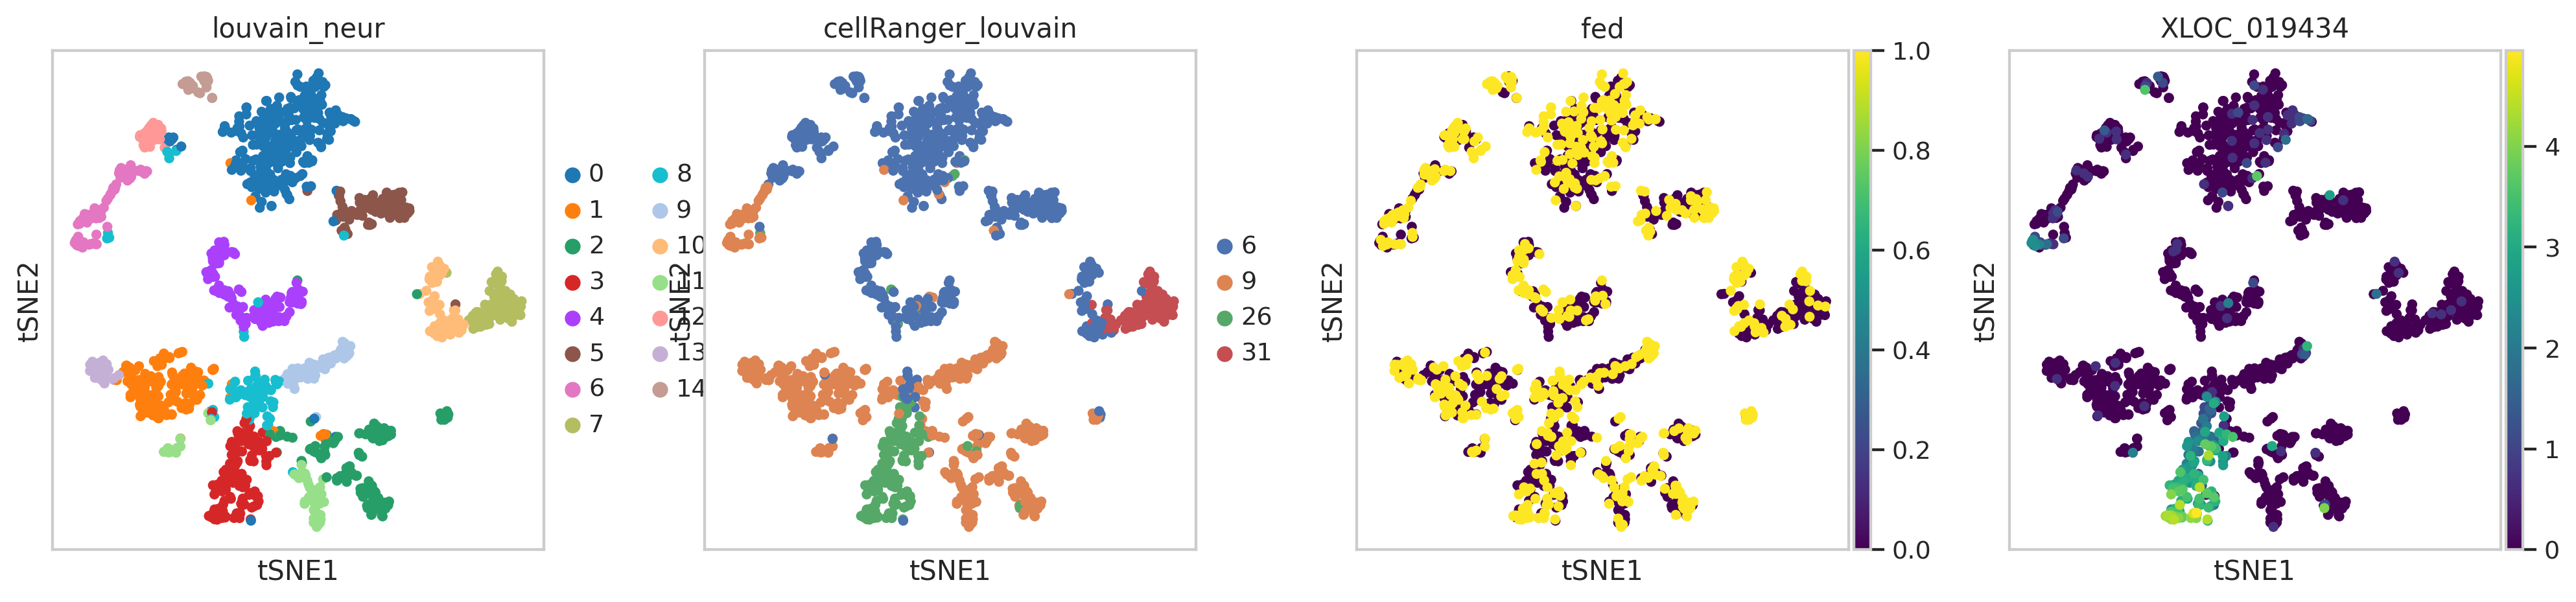

In [29]:
sc.tl.tsne(neurons, n_pcs=15,perplexity=25,random_state = 42) #learning_rate=250

neurons.obs['cellRanger_louvain'] = pd.Categorical(neurons.obs['cellRanger_louvain'] )
sc.pl.tsne(neurons, color=['louvain_neur','cellRanger_louvain','fed','XLOC_019434'],color_map='viridis',size=80)

In [30]:
#Get top n marker genes for each cluster

#Keep top 100 genes, 'louvain_neur' is label for neuron clusters determined using Louvain clustering algorithm
sc.tl.rank_genes_groups(neurons, 'louvain_neur',n_genes = 100,method='wilcoxon') #Using non-parametric test for significance
neurons

AnnData object with n_obs × n_vars = 1387 × 2852
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'louvain_neur'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'hvg', 'louvain_neur_colors', 'cellRanger_louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

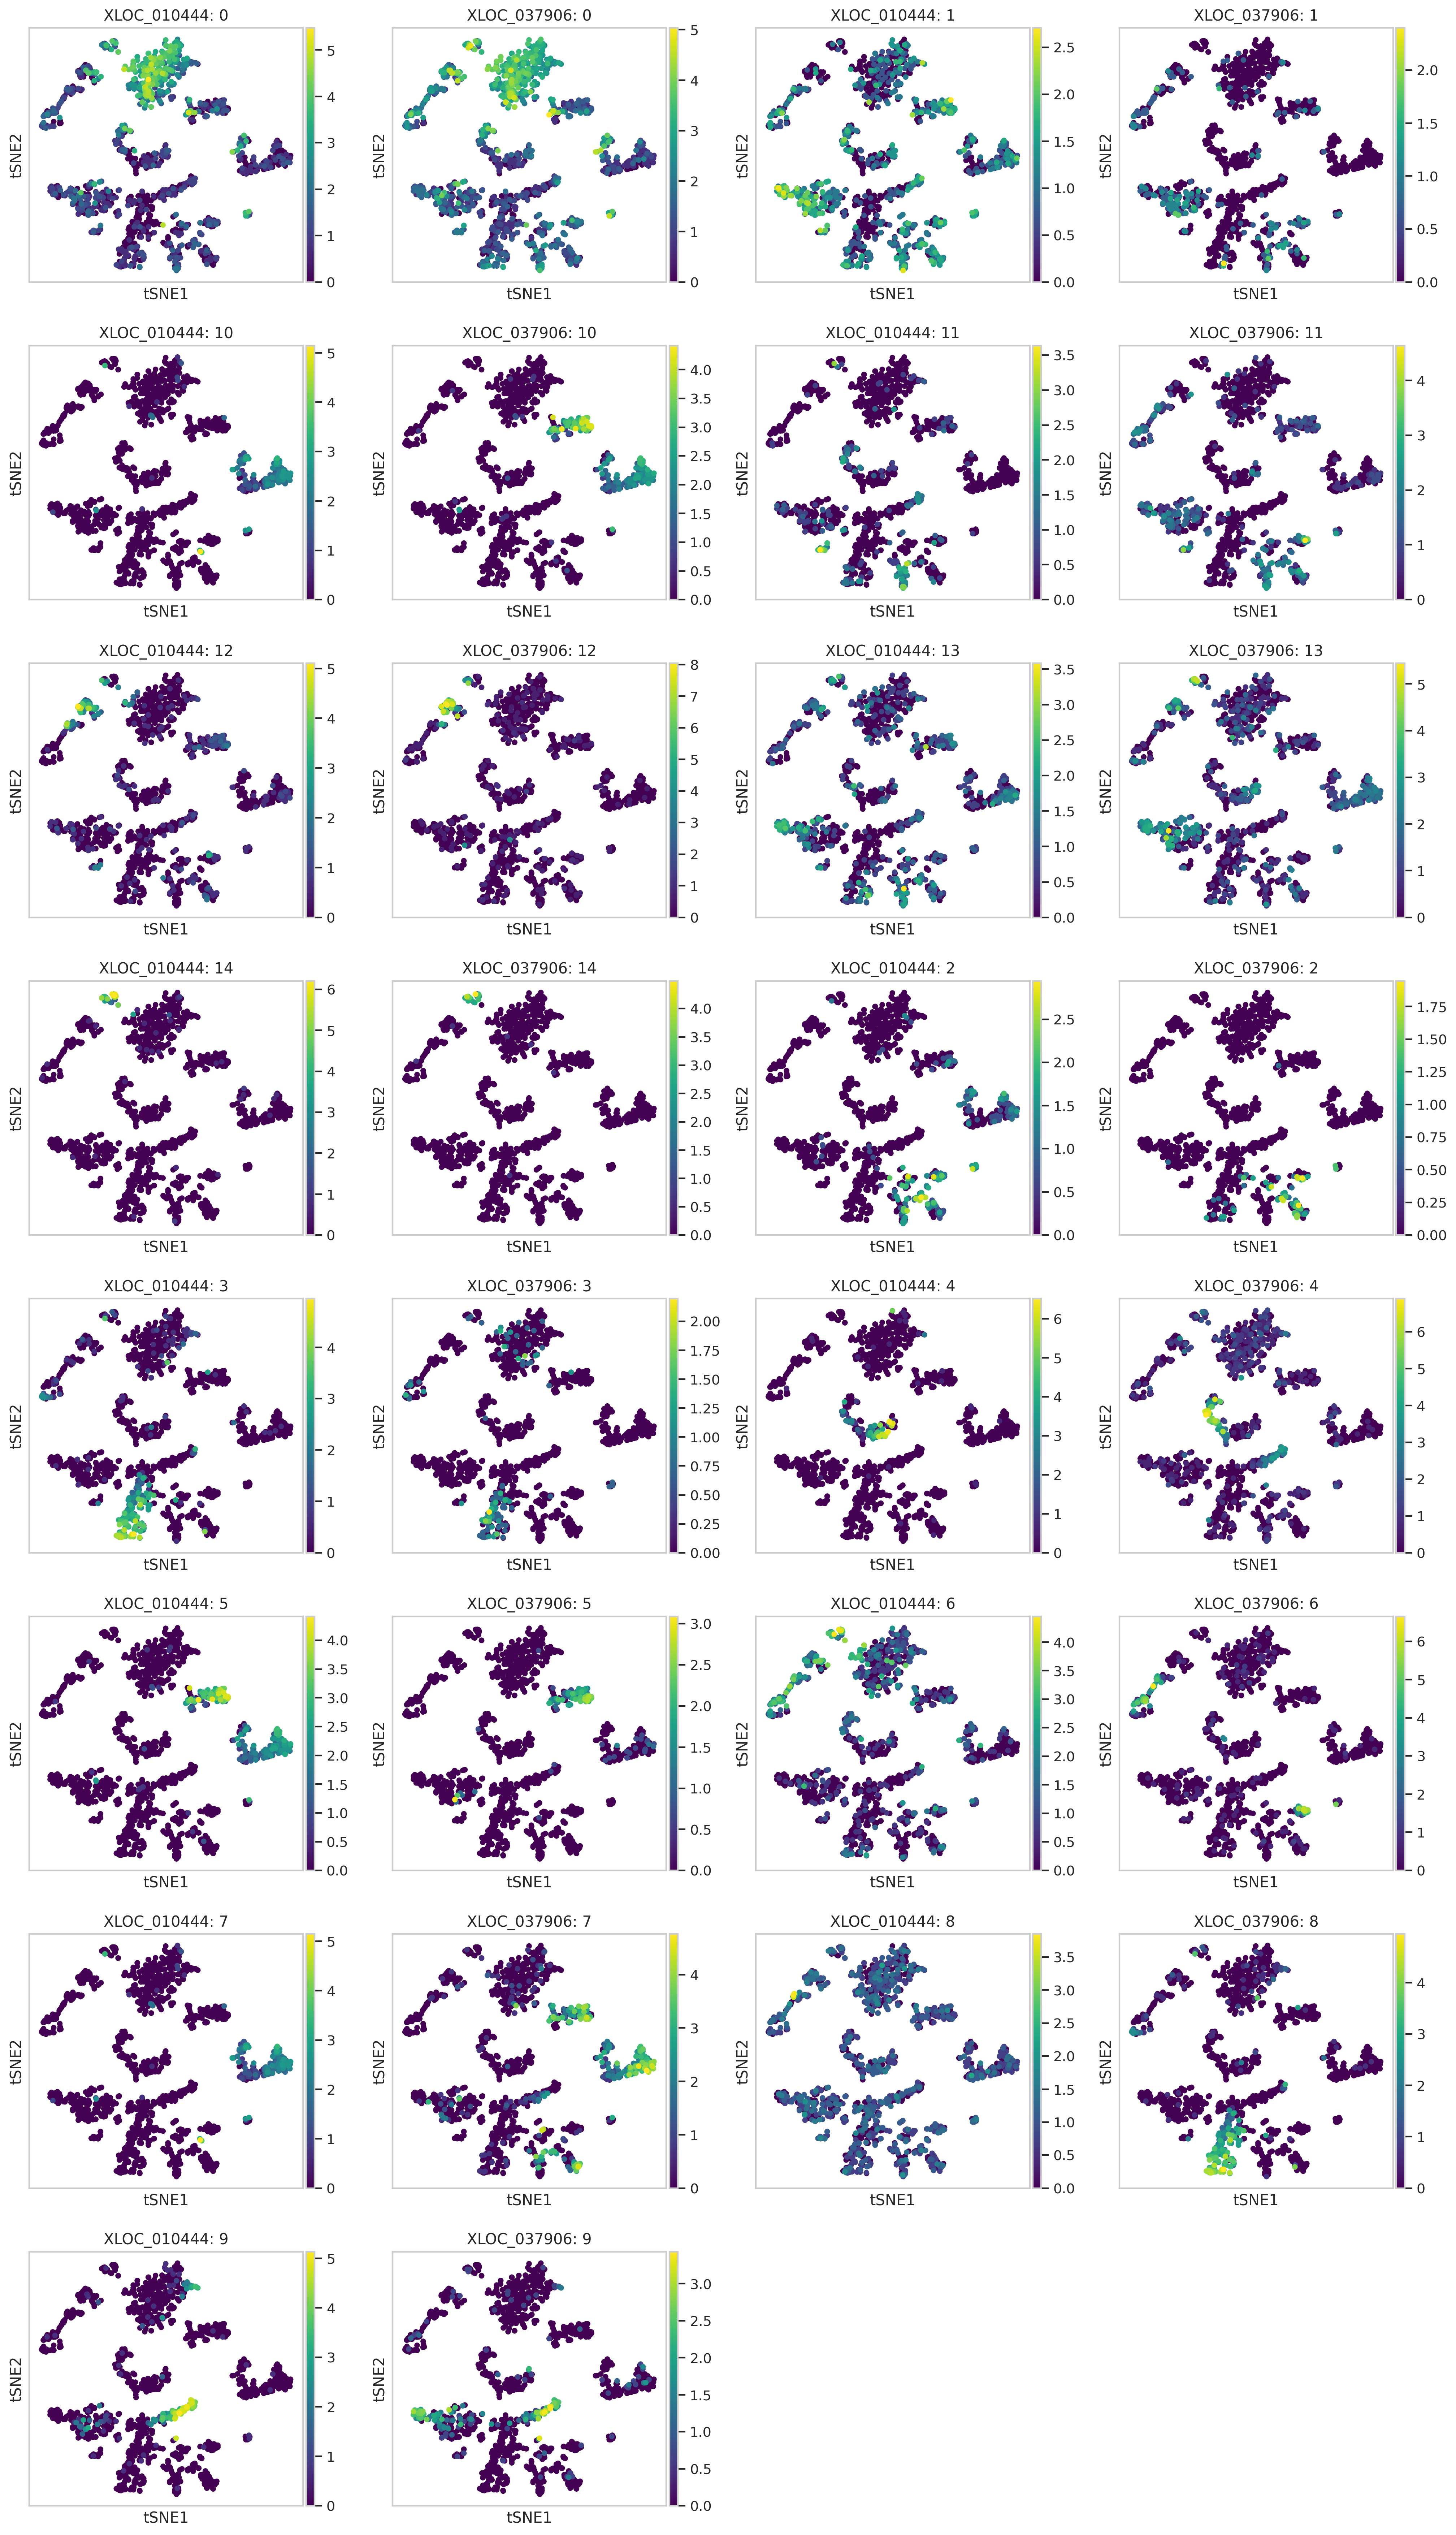

In [31]:
#Plot markers
markers = []
titles = []
for i in np.unique(neurons.obs['louvain_neur']):
     markers += list(neurons.uns['rank_genes_groups']['names'][str(i)][0:2])
     titles += [markers[0]+': '+str(i),markers[1]+': '+str(i)]

sc.pl.tsne(neurons,color=markers,color_map = 'viridis',title=titles,size = 80)

In [32]:
#Make dataframe, with 100 marker genes for each cluster + annotations
neuron_clusters = np.unique(neurons.obs['louvain_neur'])
neuron_markers = pd.DataFrame()

neurClus = []
markerGene = []
padj = []
orthoGene = []
orthoDescr = []

pantherNum = []
pantherDescr = []

goTerms = []

for i in neuron_clusters:
  genes = neurons.uns['rank_genes_groups']['names'][i]

  neurClus += list(np.repeat(i,len(genes)))
  markerGene += list(genes)
  padj += list(neurons.uns['rank_genes_groups']['pvals_adj'][i])

  for g in genes:
        
    sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
    panth_df = panther_df[panther_df[0].isin([g])]
    go_df = goTerm_df[goTerm_df[0].isin([g])]

    if len(sub_df) > 0:
      #Save first result for gene/description
      orthoGene += [list(sub_df.Gene)[0]]
      orthoDescr += [list(sub_df.Description)[0]]
    else:
      orthoGene += ['NA']
      orthoDescr += ['NA']


    if len(panth_df) > 0:
      pantherNum += [list(panth_df[1])]
      pantherDescr += [list(panth_df[2])]
    else:
      pantherNum += ['NA']
      pantherDescr += ['NA']


    if len(go_df) > 0:
      goTerms += [list(go_df[1])]
    else:
      goTerms += ['NA']
 

neuron_markers['neurClus'] = neurClus
neuron_markers['markerGene'] = markerGene
neuron_markers['padj'] = padj

neuron_markers['orthoGene'] = orthoGene
neuron_markers['orthoDescr'] = orthoDescr

neuron_markers['pantherID'] = pantherNum
neuron_markers['pantherDescr'] = pantherDescr

neuron_markers['goTerms'] = goTerms
     
neuron_markers.head()
#list(neurons.uns['rank_genes_groups']['names']['1'])




neurClus  ...                                            goTerms
0        0  ...                                              [nan]
1        0  ...                                              [nan]
2        0  ...      [GO:0005215,GO:0003824,GO:0008152,GO:0016491]
3        0  ...  [GO:0005737,GO:0044238,GO:0006457,GO:0019538,G...
4        0  ...  [GO:0005737,GO:0044238,GO:0005622,GO:0032991,G...

[5 rows x 8 columns]

In [33]:
#Write to csv
neuron_markers.to_csv('neuron_marker_annotations.csv')

#Read in csv (previously saved version, uploaded to Box)
neuron_markers = pd.read_csv('neuron_marker_annotations.csv',
            sep=",")
neuron_markers.head()

Unnamed: 0  ...                                            goTerms
0           0  ...                                              [nan]
1           1  ...                                              [nan]
2           2  ...    ['GO:0005215,GO:0003824,GO:0008152,GO:0016491']
3           3  ...  ['GO:0005737,GO:0044238,GO:0006457,GO:0019538,...
4           4  ...  ['GO:0005737,GO:0044238,GO:0005622,GO:0032991,...

[5 rows x 9 columns]

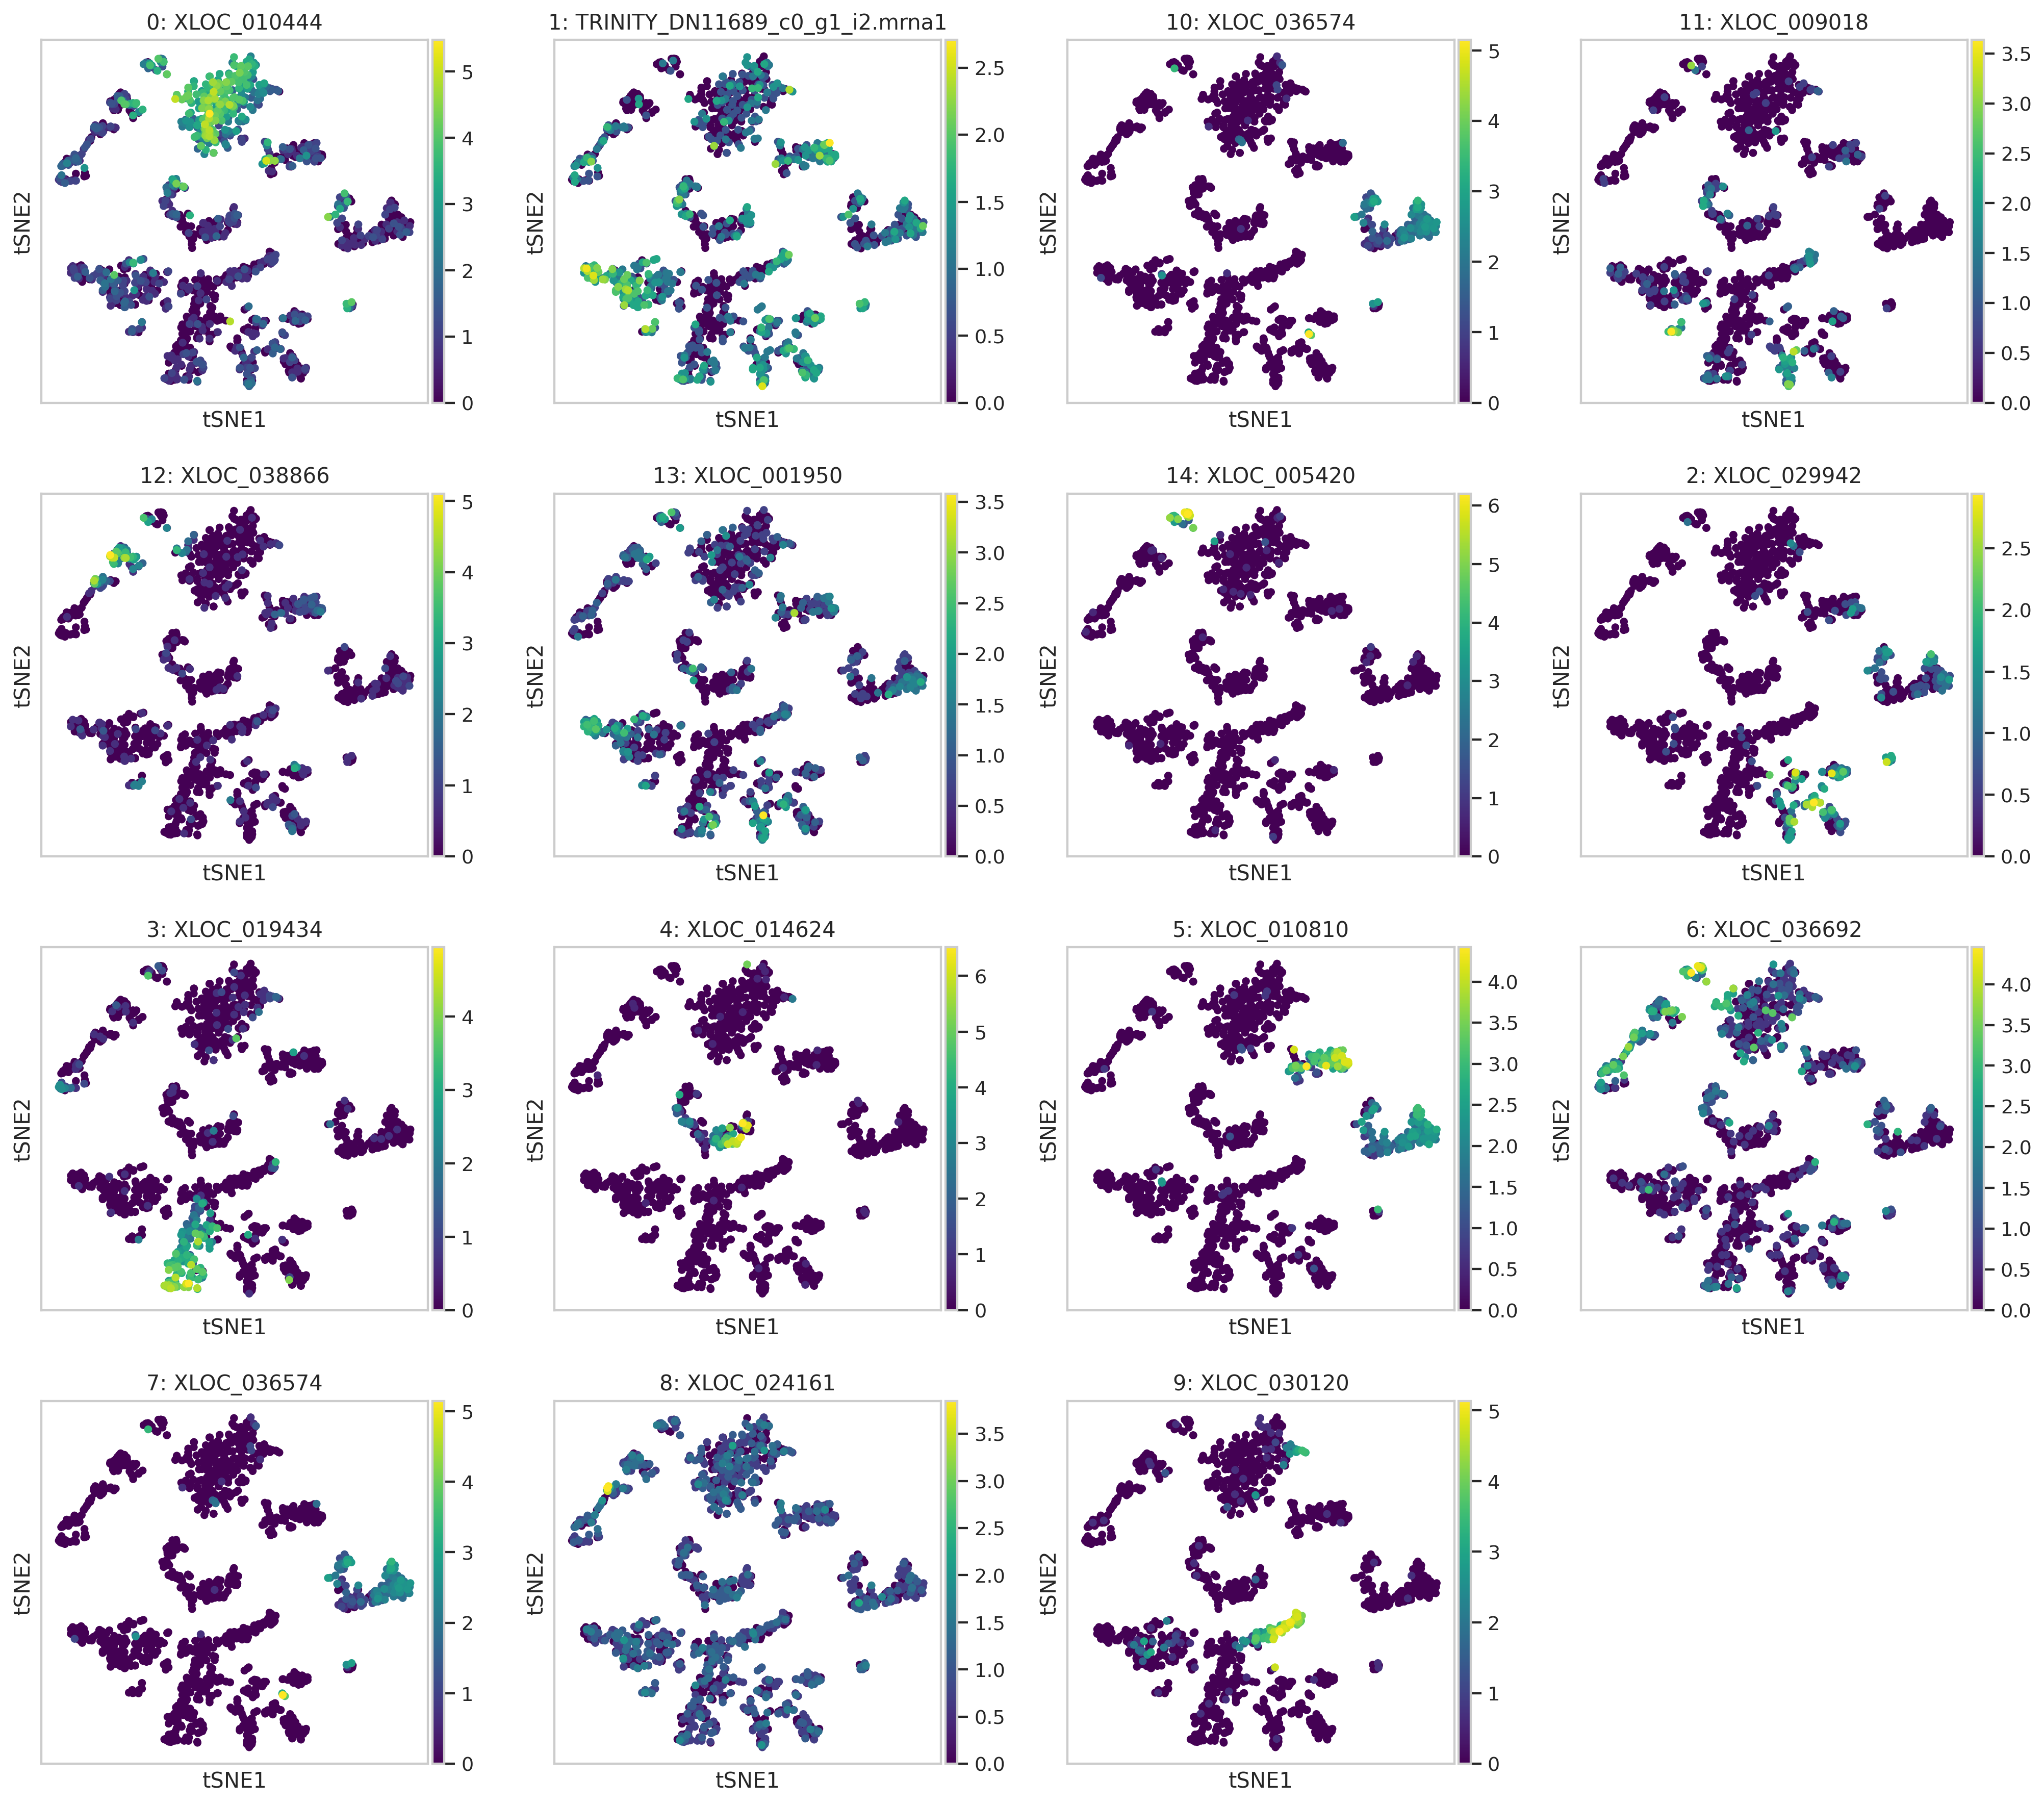

In [34]:
#Plot top marker gene for each cluster
markers = []
titles = []
clusters = np.unique(neurons.obs['louvain_neur'])
for i in clusters:
  #Subset of overall dataframe
  sub = neuron_markers[neuron_markers.neurClus.isin([i])]

  #Rank by padj
  sub = sub.sort_values(by='padj',ascending=True)
  marker = list(sub.markerGene)[0]

  markers += [marker]
  titles += [i+': '+marker]

sc.pl.tsne(neurons,color=markers,color_map = 'viridis',title=titles,size=80)

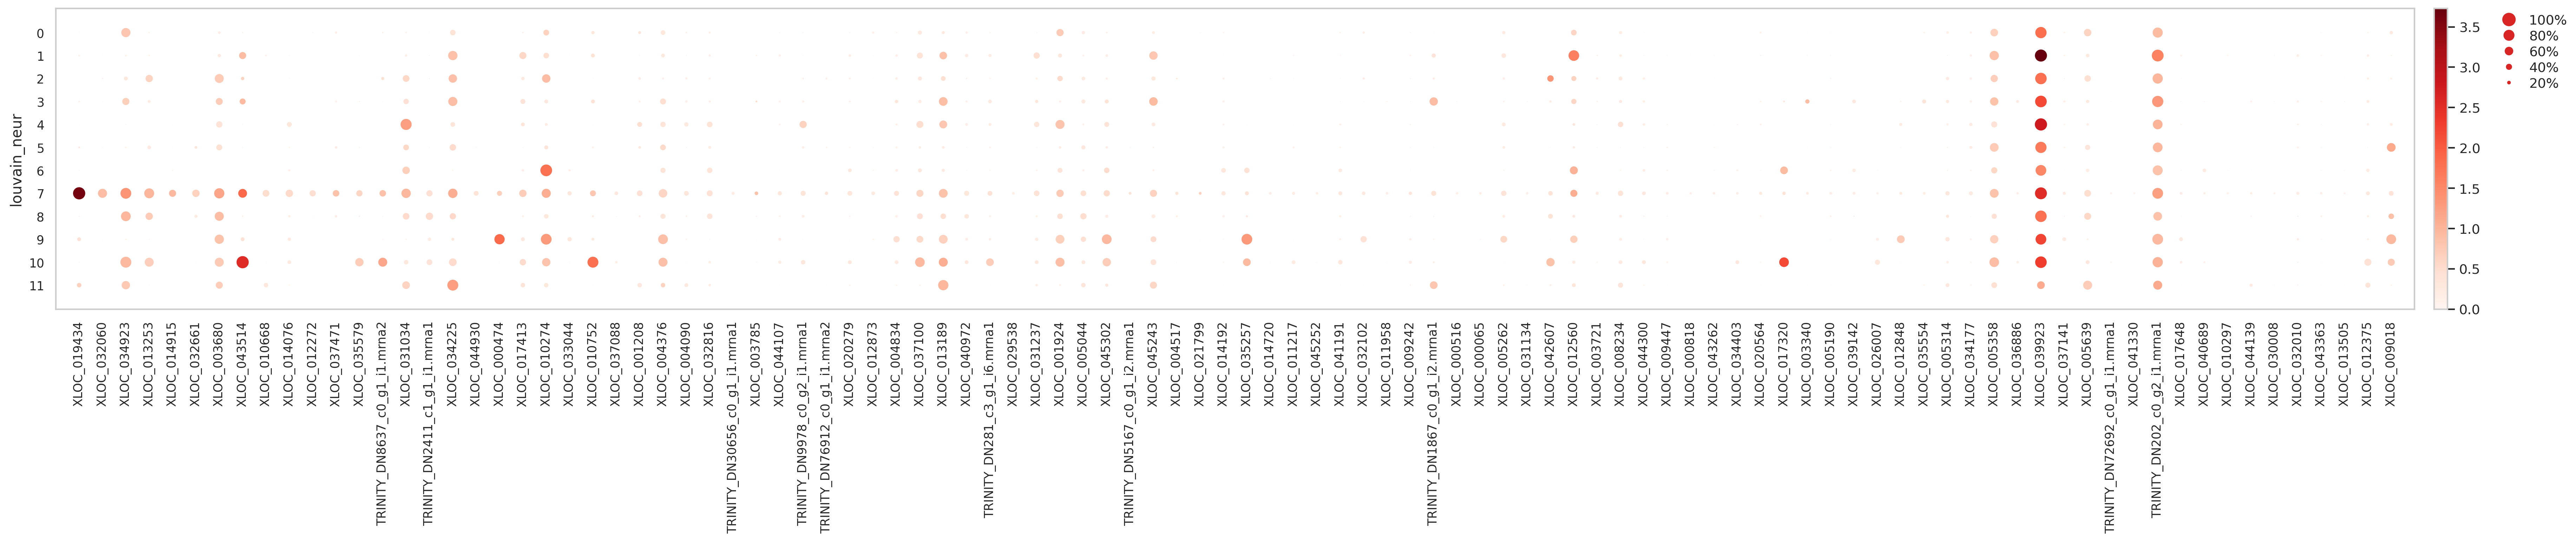

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[35.0, 0, 0.2, 0.5, 0.25])

In [110]:
#Plot marker gene expression for particular cluster as dotplot

#Example: Top 100 markers for cluster 1
markers = list(neuron_markers[neuron_markers.neurClus.isin(['7'])].markerGene)
sc.pl.dotplot(neurons, var_names=markers, groupby='louvain_neur')

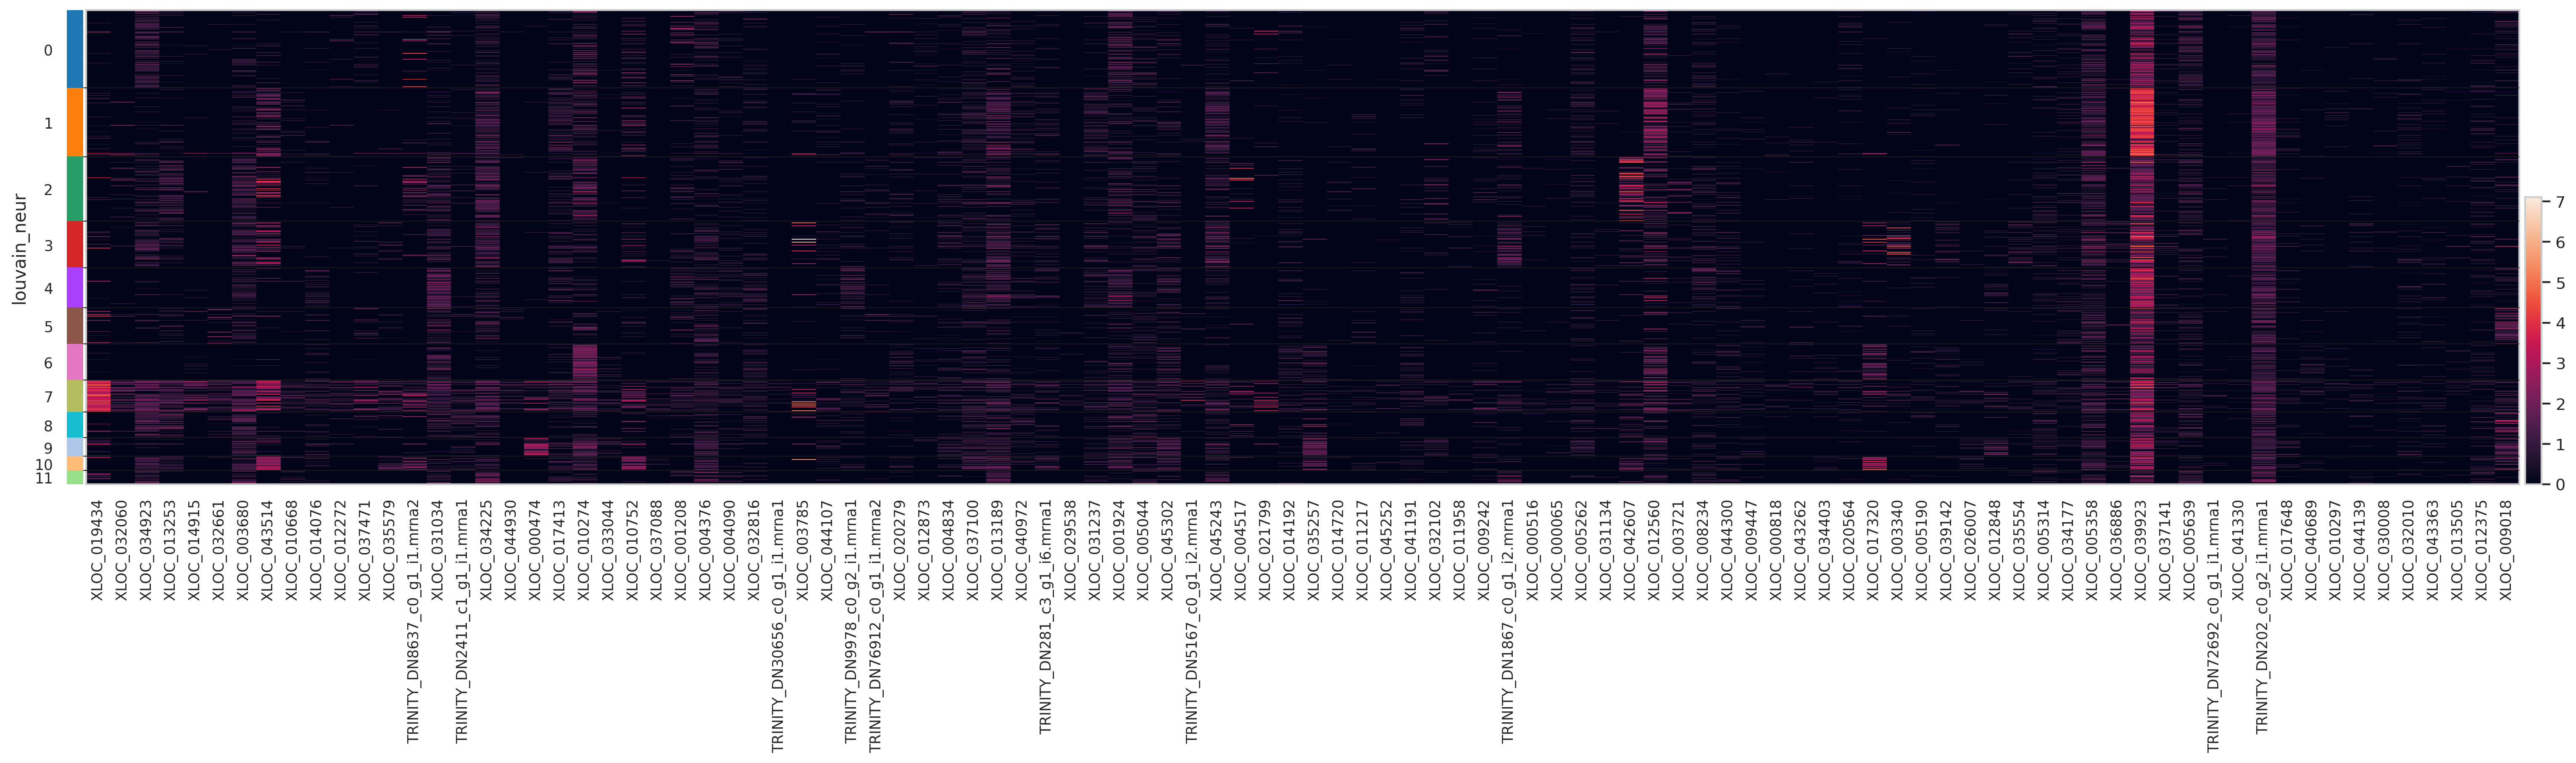

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 30.0, 0, 0.2])

In [111]:
#Plot marker genes as heatmap
sc.pl.heatmap(neurons, var_names=markers, groupby='louvain_neur',show_gene_labels=True)

In [35]:
neurons.write('neuron_subpops_fs.h5ad')

###**DESeq2 Analysis Between Fed and Starved Cells**

In [36]:
#Remove clusters with < 5 cells per condition
bus_fs_raw = anndata.read("3l60szs0e9hgaax4q9dbuehgoo092xww")

bus_fs_raw = bus_fs_raw[neurons.obs_names,]
#bus_fs_raw.obs['orgID'] = bus_fs_clus.obs['orgID']
bus_fs_raw.obs['fed'] = neurons.obs['fed']
bus_fs_raw.obs['louvain_neur'] = neurons.obs['louvain_neur']
bus_fs_raw


#clusSize

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 1387 × 46716
    obs: 'batch', 'fed', 'louvain_neur'

In [37]:
def clusToKeep(bus_fs_clus):
  keep = []
  clusSize = {}
  for i in np.unique(bus_fs_clus.obs['louvain_neur']):
      cells = bus_fs_clus[bus_fs_clus.obs['louvain_neur'].isin([i])]
      fed_cells = len(cells[cells.obs['fed']==True].obs_names)
      starv_cells = len(cells[cells.obs['fed']==False].obs_names)
      min_cells = np.min([fed_cells,starv_cells])
      if min_cells > 5:
        keep += [i]
        #clusSize[i] = min_cells
  return keep

#Subsample from full dataset, across each cluster
def getSampled_Cluster(bus_fs_clus,bus_fs_raw,keep):

  subSample = 100
  cellNames = np.array(bus_fs_clus.obs_names)
  fed = np.array(list(bus_fs_clus.obs['fed'] == True))
  starv = np.array(list(bus_fs_clus.obs['fed'] == False))

  allCells = []
  for i in keep:  
      cells = np.array(list(bus_fs_clus.obs['louvain_neur'].isin([i])))
      fed_cells = list(np.where(fed & cells)[0])
      starv_cells = list(np.where(starv & cells)[0])
      
      #Take all cells if < subSample
      if len(fed_cells) >= subSample:
          fed_choice = random.sample(fed_cells,subSample)
      else:
          fed_choice = fed_cells
          
      if len(starv_cells) >= subSample:
          starv_choice = random.sample(starv_cells,subSample)
      else:
          starv_choice = starv_cells
          
          
      pos = list(fed_choice)+list(starv_choice)
      allCells += list(cellNames[pos])

      
  sub_raw = bus_fs_raw[allCells,:]
  return sub_raw

#Instantiate dataframe with gene names
def makeDF_forR(sub_raw):
  fullDF = pd.DataFrame(scipy.sparse.csr_matrix.toarray(sub_raw.X).T, index = sub_raw.var_names.tolist(), columns= sub_raw.obs_names.tolist())
  conds = sub_raw.obs['fed'].tolist()
  #ids = sub_jelly4Raw.obs['orgID'].tolist()
  clus = sub_raw.obs['louvain_neur'].tolist()

  reps = np.repeat(0,len(sub_raw.obs_names))

  length = len(sub_raw[sub_raw.obs['fed'] == True].obs_names)
  reps[sub_raw.obs['fed'] == True] = range(1,length+1)

  length = len(sub_raw[sub_raw.obs['fed'] == False].obs_names)
  reps[sub_raw.obs['fed'] == False] = range(1,length+1)


  sampleDF = pd.DataFrame({'cell_ID': fullDF.columns}) \
          .assign(condition = conds) \
          .assign(replicate = reps) \
          .assign(cluster = clus) 
  sampleDF.index = sampleDF.cell_ID
  print(sampleDF.head())

  fullDF.to_csv('fullDF.csv')
  sampleDF.to_csv('sampleDF.csv')

In [38]:
#For neuron subpopulations
#n_genes = 10000
keep = clusToKeep(neurons)
sub_raw = getSampled_Cluster(neurons,bus_fs_raw,keep)

sub_raw_copy = sub_raw.copy()
sc.pp.filter_cells(sub_raw_copy, min_counts=0)
sc.pp.filter_genes(sub_raw_copy, min_counts=1)
sc.pp.normalize_per_cell(sub_raw_copy, counts_per_cell_after=1e4)
sc.pp.log1p(sub_raw_copy)

#sc.pp.highly_variable_genes(sub_raw_copy,n_top_genes=8000)
sub_raw = sub_raw[:,sub_raw_copy.var_names] #['highly_variable']
sub_raw

View of AnnData object with n_obs × n_vars = 1309 × 18055
    obs: 'batch', 'fed', 'louvain_neur'

In [39]:
makeDF_forR(sub_raw)

                               cell_ID  condition  replicate cluster
cell_ID                                                             
AACCATGCATCACAAC-2  AACCATGCATCACAAC-2       True          1       0
GCTCTGTAGGACTGGT-2  GCTCTGTAGGACTGGT-2       True          2       0
TCTGGAAAGTAATCCC-2  TCTGGAAAGTAATCCC-2       True          3       0
TGAGCCGGTCACACGC-2  TGAGCCGGTCACACGC-2       True          4       0
ACAGCCGTCGACAGCC-2  ACAGCCGTCGACAGCC-2       True          5       0


In [40]:
%%R 
fullDF <- read.csv(file = 'fullDF.csv')
sampleDF <- read.csv(file = 'sampleDF.csv')
head(sampleDF)

             cell_ID          cell_ID.1 condition replicate cluster
1 AACCATGCATCACAAC-2 AACCATGCATCACAAC-2      True         1       0
2 GCTCTGTAGGACTGGT-2 GCTCTGTAGGACTGGT-2      True         2       0
3 TCTGGAAAGTAATCCC-2 TCTGGAAAGTAATCCC-2      True         3       0
4 TGAGCCGGTCACACGC-2 TGAGCCGGTCACACGC-2      True         4       0
5 ACAGCCGTCGACAGCC-2 ACAGCCGTCGACAGCC-2      True         5       0
6 GCTCCTAAGAGAACAG-1 GCTCCTAAGAGAACAG-1      True         6       0


In [41]:
%%R
rownames(sampleDF) <- sampleDF$cell_ID 
#Replace '.' in cell barcodes with '-'
rownames(fullDF) <- fullDF$X
colnames(fullDF) <- gsub("\\.", "-", colnames(fullDF))
fullDF <- subset(fullDF, select = -c(X) )
head(fullDF)

sampleDF <- subset(sampleDF, select = -c(cell_ID.1) )
# head(sampleDF)
sampleDF$condition <- factor(sampleDF$condition, labels = c("starved", "fed"))

In [ ]:

%%R 
install.packages("BiocManager")
BiocManager::install(version = "3.10")


In [ ]:
#Make output directory
!mkdir kallistoDEAnalysis_Neur

!sudo apt-get update
!sudo apt-get install libxml2-dev
!sudo apt-get install r-cran-xml
!sudo apt-get install libcurl4-openssl-dev

In [44]:
%%R 
#install.packages("DESeq2",repos = "http://cran.us.r-project.org")
BiocManager::install("DESeq2")
library('DESeq2')

In [ ]:
%%R 
#install.packages("DESeq2",repos = "http://cran.us.r-project.org")
#BiocManager::install("DESeq2")
library('DESeq2')

#library("apeglm")
#library(Rcpp)
#.libPaths()

clusters <- unique(sampleDF$cluster)
Genes <- c()
Cluster <- c()
Condition <- c() 
padj <- c()
log2FC <- c()

for (i in clusters){
 
        indices = which(sampleDF$cluster == i)
        subset = fullDF[,indices]
        subset_meta = subset(sampleDF,cluster == i)


        dds <- DESeqDataSetFromMatrix(countData = subset, colData = subset_meta, design= ~replicate + condition)

        #Set control condition
        dds$condition <- relevel(dds$condition, ref = 'fed')
        dds <- DESeq(dds,test="LRT", reduced=~replicate, sfType="poscounts", useT=TRUE, minmu=1e-6, 
                     minReplicatesForReplace=Inf,betaPrior = FALSE)#parallel = TRUE

        #Starv v Fed results
        res <- results(dds,alpha=0.05,name="condition_starved_vs_fed")
        resLFC <- res 

        resLFC <- na.omit(resLFC)
        resOrdered <- resLFC[resLFC$padj < .05,]
        #Keep log2 fold changes < -1 or > 1
        resOrdered <- resOrdered[abs(resOrdered$log2FoldChange) > 1,] 
        outcomes <- resOrdered[order(resOrdered$padj),]

        Genes <- c(Genes,row.names(outcomes))
        Cluster <- c(Cluster,rep(i,length(row.names(outcomes))))
        Condition <- c(Condition,rep('Starved',length(row.names(outcomes)))) 
        padj <- c(padj,outcomes$padj)
        log2FC <- c(log2FC,outcomes$log2FoldChange)
         
    
}

deGenesDF <- data.frame(matrix(ncol = 6, nrow = length(Genes)))
names(deGenesDF) <- c("Genes", "Cluster", "Condition","padj","padjClus","log2FC")

deGenesDF$Genes <- Genes
deGenesDF$Cluster <- Cluster
deGenesDF$Condition <- Condition
deGenesDF$padj <- padj
deGenesDF$padjClus <- padj*length(unique(Cluster))
deGenesDF$log2FC <- log2FC

write.csv(deGenesDF,'./kallistoDEAnalysis_Neur/deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample.csv')

head(deGenesDF)

In [51]:
%%R -w 20 -h 20 --units in -r 500
install.packages("UpSetR",repos = "http://cran.us.r-project.org")
library("UpSetR")

deGenesDF <- read.csv(file = './kallistoDEAnalysis_Neur/deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample.csv')

#Bonferronni correction across clusters
deGenesDF_toPlot = subset(deGenesDF,padjClus < .05)
#deGenesDF_toPlot = subset(deGenesDF_toPlot,abs(log2FC) > 2)

# Create empty list to store vectors
vecsToPlot <- list()

clusters = unique(deGenesDF_toPlot$Cluster)
for (i in 1:length(clusters)){
    subset = subset(deGenesDF_toPlot,Cluster == clusters[i])
    vecsToPlot[[i]] <- unique(subset$Genes)
}

names(vecsToPlot) <- clusters

upset(fromList(vecsToPlot), sets = as.character(clusters),nintersects= 500,order.by = "freq",
      mainbar.y.label='Gene Intersection Size',
     sets.x.label = 'Number of DE Genes',
     text.scale = c(1.5, 2, 1.5, 2, 1.3, 1.3))

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependency ‘plyr’


R[write to console]: trying URL 'http://cran.us.r-project.org/src/contrib/plyr_1.8.6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 401191 bytes (391 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to co

In [47]:
deseq_df = pd.read_csv('./kallistoDEAnalysis_Neur/deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample.csv',
            sep=",")
deseq_df.head()

Unnamed: 0                          Genes  ...      padjClus    log2FC
0           1  TRINITY_DN3615_c0_g1_i2.mrna1  ...  4.305406e-13 -1.664032
1           2                    XLOC_012731  ...  2.805702e-08 -1.017769
2           3                    XLOC_038449  ...  2.927015e-08 -1.367454
3           4                    XLOC_006128  ...  7.895359e-06 -1.034690
4           5                    XLOC_012879  ...  3.334409e-05 -2.074961

[5 rows x 7 columns]

In [48]:
orthoGene = []
orthoDescr = []

pantherNum = []
pantherDescr = []

goTerms = []

deseq_df = deseq_df[np.abs(deseq_df.log2FC) < 10]
for g in deseq_df.Genes:
        
  sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
  panth_df = panther_df[panther_df[0].isin([g])]
  go_df = goTerm_df[goTerm_df[0].isin([g])]

  if len(sub_df) > 0:
    #Save first result for gene/description
    orthoGene += [list(sub_df.Gene)[0]]
    orthoDescr += [list(sub_df.Description)[0]]
  else:
    orthoGene += ['NA']
    orthoDescr += ['NA']


  if len(panth_df) > 0:
    #Save first result for gene/description
    pantherNum += [list(panth_df[1])]
    pantherDescr += [list(panth_df[2])]
  else:
    pantherNum += ['NA']
    pantherDescr += ['NA']


  if len(go_df) > 0:
    #Save first result for gene/description
    goTerms += [list(go_df[1])]
  else:
    goTerms += ['NA']
 
deseq_df['orthoGene'] = orthoGene
deseq_df['orthoDescr'] = orthoDescr

deseq_df['pantherID'] = pantherNum
deseq_df['pantherDescr'] = pantherDescr

deseq_df['goTerms'] = goTerms
deseq_df.head()

Unnamed: 0  ...                                            goTerms
0           1  ...                                                 NA
1           2  ...  [GO:0005488,GO:0000228,GO:0043226,GO:0071840,G...
2           3  ...                                                 NA
3           4  ...  [GO:0006807,GO:0030529,GO:0043226,GO:0071840,G...
4           5  ...  [GO:0016787,GO:0044238,GO:0019538,GO:0006473,G...

[5 rows x 12 columns]

In [49]:
deseq_df.to_csv('./kallistoDEAnalysis_Neur/deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample_annotations.csv')